<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [9]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [10]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [13]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('boneage-training-dataset_261.csv', 'boneage-training-dataset-261'),
    batch_size=20, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=20, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset-200.csv', 'boneage-test-dataset-200'),
    batch_size=20, shuffle=True, **kwargs)

In [15]:
device

device(type='cpu')

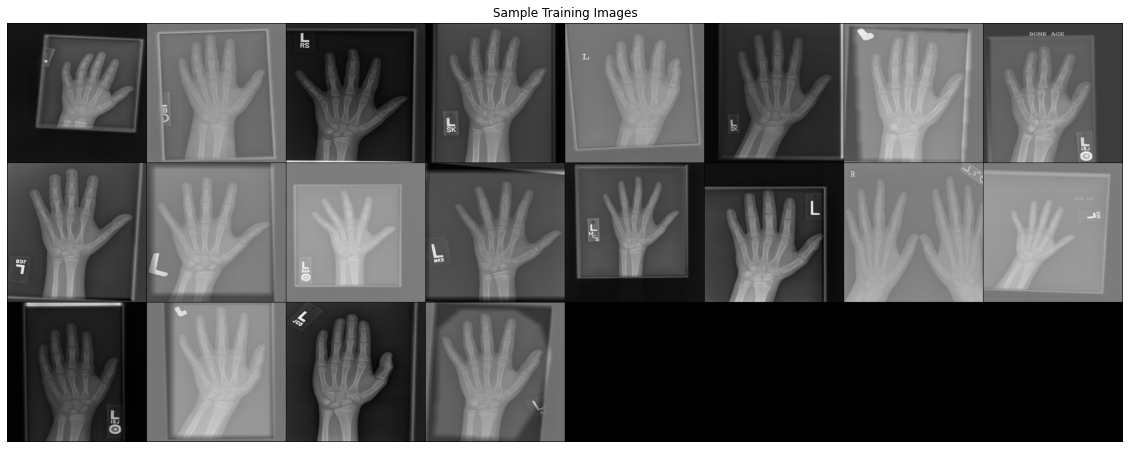

In [16]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [17]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=1e-3, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [18]:
train_losses = []
val_losses = []
for epoch in range(5):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'test_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.npy')

Train Epoch: 0 [0/261 (0%)]	Loss: 111.352310
Train Epoch: 0 [20/261 (7%)]	Loss: 85.862544
Train Epoch: 0 [40/261 (14%)]	Loss: 63.882627
Train Epoch: 0 [60/261 (21%)]	Loss: 82.788419
Train Epoch: 0 [80/261 (29%)]	Loss: 66.236730
Train Epoch: 0 [100/261 (36%)]	Loss: 43.849957
Train Epoch: 0 [120/261 (43%)]	Loss: 39.747292
Train Epoch: 0 [140/261 (50%)]	Loss: 47.805161
Train Epoch: 0 [160/261 (57%)]	Loss: 40.440595
Train Epoch: 0 [180/261 (64%)]	Loss: 58.099696
Train Epoch: 0 [200/261 (71%)]	Loss: 40.087449
Train Epoch: 0 [220/261 (79%)]	Loss: 29.468072
Train Epoch: 0 [240/261 (86%)]	Loss: 49.972087
Train Epoch: 0 [13/261 (93%)]	Loss: 104.453805

 Train set: Average loss: 78.6252


 Validation set: Average loss: 82.1367

Train Epoch: 1 [0/261 (0%)]	Loss: 51.514046
Train Epoch: 1 [20/261 (7%)]	Loss: 23.704833
Train Epoch: 1 [40/261 (14%)]	Loss: 46.553188
Train Epoch: 1 [60/261 (21%)]	Loss: 45.083765
Train Epoch: 1 [80/261 (29%)]	Loss: 31.070615
Train Epoch: 1 [100/261 (36%)]	Loss: 61.30379

In [19]:
checkpoint = torch.load('model_checkpoint.npy')
checkpoint

{'epoch': 5,
 'train_loss': [78.6252212277201,
  40.33128981726898,
  37.448052158842444,
  36.26080197713483,
  36.23958573758949],
 'test_loss': [82.13673068478582,
  57.57897363589205,
  36.485308540147805,
  39.338463032519215,
  42.6561756484219],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[ 0.3570, -0.5533, -0.1795],
                         [-0.1840,  0.2853,  0.2629],
                         [-0.1651, -0.5815, -0.0856]]],
               
               
                       [[[-0.1864, -0.0999, -0.3696],
                         [-0.2454,  0.2493, -0.2029],
                         [ 0.0440,  0.1557,  0.4776]]],
               
               
                       [[[ 0.2269, -0.2488, -0.0227],
                         [ 0.5007,  0.6343, -0.1337],
                         [-0.6796,  0.1928, -0.0525]]],
               
               
                       [[[ 0.0142, -0.5007,  0.8564],
                         [ 0.5907, -0.6122,  0.4796],
      

In [20]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [21]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [22]:
epoch = checkpoint['epoch']
epoch

5

In [23]:
train_loss = checkpoint['train_loss']
train_loss

[78.6252212277201,
 40.33128981726898,
 37.448052158842444,
 36.26080197713483,
 36.23958573758949]

In [24]:
test_loss = checkpoint['test_loss']
test_loss

[82.13673068478582,
 57.57897363589205,
 36.485308540147805,
 39.338463032519215,
 42.6561756484219]

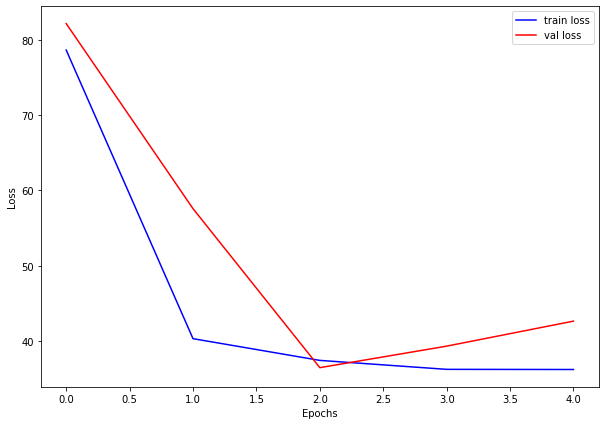

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [27]:
cd pytorch-grad-cam

/content/pytorch-grad-cam


In [28]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [29]:
!pip install --upgrade torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = BoneAgePredictor()
model
model.eval()

# initialize Grad-CAM
target_layer = model.conv5
cam = GradCAM(model, target_layer, use_cuda)

for input, target in validation_data_loader:
    # move inputs and targets to device
    input, target = input.to(device), target.to(device)

    # generate cam
    output = model(input)
    loss = F.l1_loss(output, target)
    loss.backward()
    cam(input_tensor=input)

    # visualize cam
    heatmap = cam.generate(target_category=0)
    cam_image = cam.overlay(heatmap, input)

TypeError: ignored

In [31]:
conv5 = nn.Conv2d(128, 128, 3)
weights = conv5.state_dict()['weight']
weights

tensor([[[[-1.7502e-02, -2.1162e-02,  2.1368e-02],
          [-1.6327e-02,  1.3601e-02, -6.3221e-03],
          [ 2.0984e-02,  1.6924e-02, -1.0967e-02]],

         [[ 2.1832e-02, -2.4208e-02,  9.0154e-03],
          [-2.7190e-02, -1.1504e-02, -2.7781e-02],
          [ 1.2753e-02,  1.5590e-03,  1.6943e-02]],

         [[-1.7090e-02,  2.2800e-02,  1.1717e-02],
          [-1.9324e-02,  1.9405e-02, -1.8052e-02],
          [-2.2963e-02, -2.4113e-02, -1.3049e-02]],

         ...,

         [[-2.5982e-02, -2.5926e-02, -1.6939e-03],
          [ 9.3851e-03, -1.0791e-02,  9.8870e-03],
          [-2.6930e-02,  6.6396e-04,  2.9952e-04]],

         [[-9.3759e-04, -1.9368e-03, -2.5971e-02],
          [ 6.0801e-03,  1.5527e-02,  1.3987e-02],
          [ 1.2518e-02,  6.1905e-03, -1.3408e-02]],

         [[-1.1210e-02,  1.2962e-02,  2.5373e-02],
          [ 5.2914e-03, -1.3787e-02,  1.2267e-02],
          [ 1.7864e-02,  1.6965e-02,  5.8537e-03]]],


        [[[-2.3322e-02,  9.6267e-03,  5.2718e-03],
  

In [32]:
model = BoneAgePredictor()
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [33]:
target_layers = weights
target_layers

tensor([[[[-1.7502e-02, -2.1162e-02,  2.1368e-02],
          [-1.6327e-02,  1.3601e-02, -6.3221e-03],
          [ 2.0984e-02,  1.6924e-02, -1.0967e-02]],

         [[ 2.1832e-02, -2.4208e-02,  9.0154e-03],
          [-2.7190e-02, -1.1504e-02, -2.7781e-02],
          [ 1.2753e-02,  1.5590e-03,  1.6943e-02]],

         [[-1.7090e-02,  2.2800e-02,  1.1717e-02],
          [-1.9324e-02,  1.9405e-02, -1.8052e-02],
          [-2.2963e-02, -2.4113e-02, -1.3049e-02]],

         ...,

         [[-2.5982e-02, -2.5926e-02, -1.6939e-03],
          [ 9.3851e-03, -1.0791e-02,  9.8870e-03],
          [-2.6930e-02,  6.6396e-04,  2.9952e-04]],

         [[-9.3759e-04, -1.9368e-03, -2.5971e-02],
          [ 6.0801e-03,  1.5527e-02,  1.3987e-02],
          [ 1.2518e-02,  6.1905e-03, -1.3408e-02]],

         [[-1.1210e-02,  1.2962e-02,  2.5373e-02],
          [ 5.2914e-03, -1.3787e-02,  1.2267e-02],
          [ 1.7864e-02,  1.6965e-02,  5.8537e-03]]],


        [[[-2.3322e-02,  9.6267e-03,  5.2718e-03],
  

In [34]:
input_tensor = validation_data_loader
input_tensor

In [35]:
cam = GradCAM(model=model, target_layers = target_layers, use_cuda=use_cuda)
cam

AttributeError: ignored

In [36]:
class GradCAM:
    def init(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activation = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def forward(self, x):
        x = self.model.conv5(x)
        x = self.model.batch5(x)

        self.activation = x

        x = self.model.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)

        return x

    def backward(self, output):
        one_hot = output.mean(dim=0)
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

    def generate(self):
        weights = self.gradient.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activation).sum(1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze(1)
        cam = cam.detach().numpy()
        return cam

model = BoneAgePredictor()
target_layer= model.conv5
grad_cam = GradCAM(model, target_layer, use_cuda = use_cuda)
image = torch.randn(1, 3, 224, 224)

output = grad_cam.forward(image)
grad_cam.backward(output)
cam = grad_cam.generate()

TypeError: ignored

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)